# Interpolating Missing Data Based on Monitor Associations

## Load the libraries

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import glob

from scipy.stats import linregress

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold

## Load + Merge the hourly data

This section loads the hourly datasets for PM 2.5, temperature, and relative humidity from the QuantAQ network. The goal is to combine these separate files into unified, continuous datasets for each variable and then merge them together by monitor, date, and hour to form a complete record of pollutant and weather measurements.

In [9]:
# path to data
data_dir = "/Users/lewiswhite/CHAP_columbia/QuantAQ_ghana/data/"

# PM 2.5 hourly
hourly_pm25_20231024_20240816 = pd.read_csv(data_dir + "pm/summarized/pm25_community_hourly_20231024-20240816.csv")
hourly_pm25_20240816_20250901 = pd.read_csv(data_dir + "pm/summarized/pm25_community_hourly_20240816-20250901.csv")

# PM 1 hourly
hourly_pm1_20231024_20240816 = pd.read_csv(data_dir + "pm/summarized/pm1_community_hourly_20231024-20240816.csv")
hourly_pm1_20240816_20250901 = pd.read_csv(data_dir + "pm/summarized/pm1_community_hourly_20240816-20250901.csv")

# PM 10 hourly 
hourly_pm10_20231024_20240816 = pd.read_csv(data_dir + "pm/summarized/pm10_community_hourly_20231024-20240816.csv")
hourly_pm10_20240816_20250901 = pd.read_csv(data_dir + "pm/summarized/pm10_community_hourly_20240816-20250901.csv")

# temperature hourly
hourly_temp_20230815_20240820 = pd.read_csv(data_dir + "weather/summarized/temp_hourly_20230815-20240820.csv")
hourly_temp_20240816_20250901 = pd.read_csv(data_dir + "weather/summarized/temp_hourly_20240816-20250901.csv")

# relative humidity hourly 
hourly_rh_20230815_20240820 = pd.read_csv(data_dir + "weather/summarized/rh_hourly_20230815-20240820.csv")
hourly_rh_20240816_20250901 = pd.read_csv(data_dir + "weather/summarized/rh_hourly_20240816-20250901.csv")

# Combine each date range for weather / PM variables 
hourly_pm25_full = pd.concat([hourly_pm25_20231024_20240816, hourly_pm25_20240816_20250901], ignore_index=True)
hourly_pm1_full = pd.concat([hourly_pm1_20231024_20240816, hourly_pm1_20240816_20250901], ignore_index=True)
hourly_pm10_full = pd.concat([hourly_pm10_20231024_20240816, hourly_pm10_20240816_20250901], ignore_index=True)
hourly_temp_full = pd.concat([hourly_temp_20230815_20240820, hourly_temp_20240816_20250901], ignore_index=True)
hourly_rh_full = pd.concat([hourly_rh_20230815_20240820, hourly_rh_20240816_20250901], ignore_index=True)

# rename vars so distinct column names when joining full data 
hourly_pm25_full = hourly_pm25_full.rename(
    columns={
        "n_minute_obs": "n_minute_obs_pm25",
        "n_active": "n_active_pm25"
    }
)

hourly_pm1_full = hourly_pm1_full.rename(
    columns={
        "n_minute_obs": "n_minute_obs_pm1",
        "n_active": "n_active_pm1"
    }
)

hourly_pm10_full = hourly_pm10_full.rename(
    columns={
        "n_minute_obs": "n_minute_obs_pm10",
        "n_active": "n_active_pm10"
    }
)

hourly_temp_full = hourly_temp_full.rename(
    columns={
        "n_minute_obs": "n_minute_obs_temp",
        "n_active": "n_active_temp"
    }
)


hourly_rh_full = hourly_rh_full.rename(
    columns={
        "n_minute_obs": "n_minute_obs_rh",
        "n_active": "n_active_rh"
    }
)


# ---- Check for duplicates before joining ----
dups_pm25 = hourly_pm25_full.duplicated(subset=["monitor", "date", "hour"]).sum()
dups_pm1 = hourly_pm1_full.duplicated(subset=["monitor", "date", "hour"]).sum()
dups_pm10 = hourly_pm10_full.duplicated(subset=["monitor", "date", "hour"]).sum()
dups_temp = hourly_temp_full.duplicated(subset=["monitor", "date", "hour"]).sum()
dups_rh = hourly_rh_full.duplicated(subset=["monitor", "date", "hour"]).sum()

print(f"PM 25 duplicates: {dups_pm25}")
print(f"PM 1 duplicates: {dups_pm1}")
print(f"PM 10 duplicates: {dups_pm10}")
print(f"Temp duplicates: {dups_temp}")
print(f"RH duplicates: {dups_rh}")


PM 25 duplicates: 0
PM 1 duplicates: 0
PM 10 duplicates: 0
Temp duplicates: 0
RH duplicates: 0


In [10]:
## Merge the PM and weather data 
hourly_full = (
    hourly_pm25_full # start with hourly pm 2.5
    .merge(
        hourly_pm1_full, # add pm 1
        on = ["monitor", "date", "hour"],
        how = "outer"
    )
    .merge(
        hourly_pm10_full, # add pm 10
        on = ["monitor", "date", "hour"],
        how = "outer"
    )
    .merge(
        hourly_temp_full, # add hourly temp
        on=["monitor", "date", "hour"],
        how="outer"
    )
    .merge(
        hourly_rh_full, # add hourly RH 
        on=["monitor", "date", "hour"],
        how="outer"
    )
)

## drop NA hours (need to adjust weather data cleaning so midnight counts as hour 0)
hourly_full = hourly_full.dropna(subset=["hour"])

# Normalize identifiers 
hourly_full["monitor"] = (
    hourly_full["monitor"].astype(str)
      .str.strip()
      .str.upper()
      .str.replace(r'[\u2010\u2011\u2012\u2013\u2014\u2015]', '-', regex=True)
      .str.replace(r'\s+', '', regex=True)
)


# ensure date formats work 
hourly_full["date"] = pd.to_datetime(hourly_full["date"])

hourly_full["date"] = pd.to_datetime(hourly_full["date"]).dt.normalize()

hourly_full["timestamp"] = hourly_full["date"] + pd.to_timedelta(hourly_full["hour"], unit="h")

# check out data
print(hourly_full.head)
print(hourly_full["monitor"].nunique())

<bound method NDFrame.head of              monitor       date  hour  n_minute_obs_pm25  mean_pm25  \
0          MOD-00077 2024-10-31   0.0               60.0  42.607167   
1          MOD-00077 2024-10-31   1.0               60.0  29.868667   
2          MOD-00077 2024-10-31   2.0               60.0  27.362000   
3          MOD-00077 2024-10-31   3.0               60.0  37.985000   
4          MOD-00077 2024-10-31   4.0               60.0  30.867667   
...              ...        ...   ...                ...        ...   
851845  MOD-PM-01093 2025-09-01  20.0                0.0        NaN   
851846  MOD-PM-01093 2025-09-01  21.0                0.0        NaN   
851847  MOD-PM-01093 2025-09-01  22.0                0.0        NaN   
851848  MOD-PM-01093 2025-09-01  23.0                0.0        NaN   
851849  MOD-PM-01093 2025-09-02   0.0                0.0        NaN   

        n_active_pm25  fleet_average_pm25  n_minute_obs_pm1   mean_pm1  \
0                20.0           14.966551  

## Examine missingness

This section evaluates data completeness across monitors and days to understand coverage and identify patterns of missing PM 2.5 data. It calculates the proportion of valid hourly PM₂.₅ readings per monitor-day (out of 24 expected hours) and visualizes the results as a heatmap of daily completeness.

In [11]:

# compute daily completeness (hours with valid mean_pm25 / expected 24)
daily_counts = (
    hourly_full
    .dropna(subset=["mean_pm25"])  # only keep rows where PM2.5 is not missing
    .groupby(["monitor", "date"], as_index=False)
    .agg(n_hours=("hour", "nunique"))
)
daily_counts["pct_complete"] = daily_counts["n_hours"] / 24

In [12]:
daily_counts.info()
daily_counts.head()

# reshape data wide so each row is monitor and each column is date with the percent complete for the date
pivot_df = daily_counts.pivot(index="monitor", columns="date", values="pct_complete")

print(pivot_df.shape)
print(pivot_df.index.nunique(), "unique monitors in pivot table")
print(pivot_df.columns.nunique(), "unique dates in pivot table")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21251 entries, 0 to 21250
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   monitor       21251 non-null  object        
 1   date          21251 non-null  datetime64[ns]
 2   n_hours       21251 non-null  int64         
 3   pct_complete  21251 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 664.2+ KB
(66, 636)
66 unique monitors in pivot table
636 unique dates in pivot table


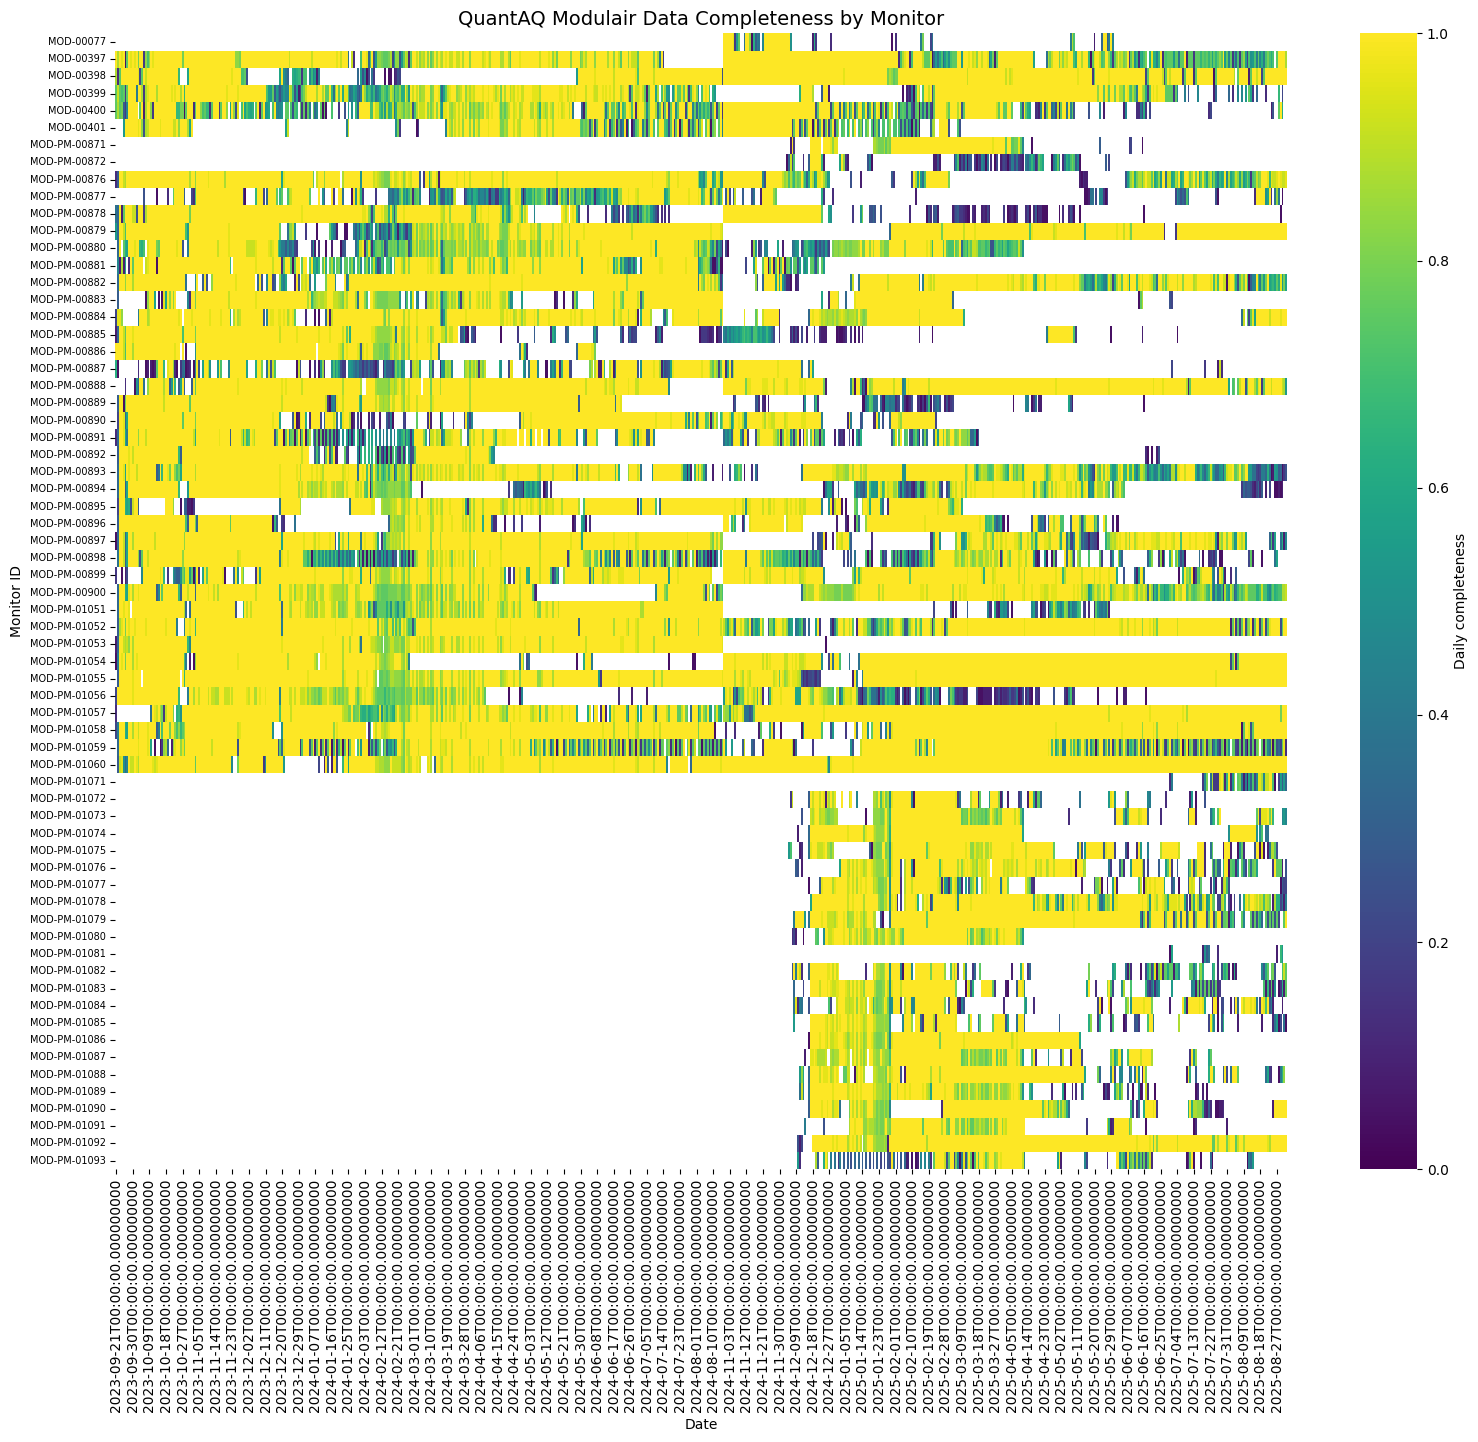

In [13]:
order = list(pivot_df.index)  # keep all 66 monitors
fig_height = max(12, len(order) * 0.22)

plt.figure(figsize=(16, fig_height))
ax = sns.heatmap(
    pivot_df.loc[order],
    cmap="viridis",
    vmin=0, vmax=1,
    cbar_kws={"label": "Daily completeness"},
    mask=pivot_df.loc[order] == 0  # hide background when completeness = 0
)

# show all y labels
ax.set_yticks(np.arange(len(order)) + 0.5)
ax.set_yticklabels(order, fontsize=7, rotation=0)

# style tweaks
ax.set_facecolor("white")  # make background white for masked cells
plt.title("QuantAQ Modulair Data Completeness by Monitor", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Monitor ID")
plt.tight_layout()
plt.show()


# Imputation

## Create Train/Test Sets

This section creates reproducible training and test datasets. The `fleet_average()` function precomputes leave-one-out fleet means for each timestamp. We restrict to hours where at least three monitors were active (to ensure each fleet average is based on at least two other monitors).  

Train and test splits are saved and reused for consistent evaluation across models.

In [14]:
from sklearn.model_selection import train_test_split

# --- Data prep ---
df_full_clean = hourly_full.copy()

# function computes a leave-one-out fleet average for each timestamp
def fleet_average(group):
    n_reporting = group['mean_pm25'].notna().sum() # number of monitors with non-missing PM 2.5 readings.
    group['n_reporting'] = n_reporting
    if n_reporting > 2: # requires at least 3 monitors reporting to complete fleet average (takes average of 2 other monitors)
        group['fleet_avg_pm25'] = (
            (group['mean_pm25'].sum(skipna=True) - group['mean_pm25']) / (n_reporting - 1) # total pm 2.5 - monitors pm2.5 / number of other monitors
        )
    else:
        group['fleet_avg_pm25'] = np.nan
    return group

# apply above function 
df_full_clean = df_full_clean.groupby("timestamp", group_keys=False).apply(fleet_average)

# Add time-based predictors
df_full_clean["month"] = df_full_clean["date"].dt.month
df_full_clean["dow"] = df_full_clean["date"].dt.dayofweek
df_full_clean["hour"] = df_full_clean["hour"].astype(int)

# Drop rows with missing target
df_full_clean = df_full_clean.dropna(subset=["mean_pm25"]).reset_index(drop=True)

# --- Create and save split indices ---
train_idx, test_idx = train_test_split(
    np.arange(len(df_full_clean)),
    test_size=0.2,
    random_state=222
)

# save training and test data splits so can directly compare performance across models 
np.save("train_idx.npy", train_idx)
np.save("test_idx.npy", test_idx)

# test create train/test data frames
train_df = df_full_clean.iloc[train_idx].copy()
test_df = df_full_clean.iloc[test_idx].copy()

print(f"Training rows: {len(train_df)}, Test rows: {len(test_df)}")

Training rows: 351907, Test rows: 87977


/var/folders/n_/cw4pq10d2x77w7v_xrb2xw5h0000gn/T/ipykernel_4994/688329228.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_full_clean = df_full_clean.groupby("timestamp", group_keys=False).apply(fleet_average)


## Fleet-Average (leave one out) Imputation (Baseline)

We recompute a leave-one-out fleet average (fleet_leave_one()) as a simple baseline model to serve as comparison for future models. 

We tune the minimum number of active monitors (min_active) required for the fleet mean, evaluating different thresholds to find the best-performing setting.

This helps benchmark how accurate a pure fleet-based imputation is before adding more predictors and trying other types of models. 

In [15]:
# Reuse stored split

train_idx = np.load("train_idx.npy")
test_idx = np.load("test_idx.npy")

train_df = df_full_clean.iloc[train_idx].copy()
test_df = df_full_clean.iloc[test_idx].copy()



In [16]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Create data subsets using saved indices
train_df = df_full_clean.iloc[train_idx].copy()
test_df  = df_full_clean.iloc[test_idx].copy()

def fleet_leave_one(df, min_active=2):
    """Compute leave-one-out fleet mean for each monitor/hour combination."""
    g = df.groupby("timestamp", group_keys=False)
    sums = g["mean_pm25"].sum(min_count=1)
    counts = g["mean_pm25"].count()
    
    # Merge precomputed totals back
    tmp = df.merge(
        pd.DataFrame({
            "timestamp": sums.index,
            "sum_all": sums.values,
            "cnt_all": counts.values
        }),
        on="timestamp", how="left"
    )
    
    # Leave-one-out average
    num = tmp["sum_all"] - tmp["mean_pm25"]
    den = tmp["cnt_all"] - 1
    loo = num / den
    
    # Enforce minimum number of *other* active monitors
    loo[(tmp["cnt_all"] - 1) < min_active] = np.nan
    
    # Keep index alignment
    loo.index = df.index
    return loo

# --- TUNE on TRAIN ---
candidates = [1, 2, 3, 5, 10, 20]
train_eval = []
full_loo_cache = {}

# Compute LOO (leave one out) for each threshold once (cached)
for m in candidates:
    if m not in full_loo_cache:
        full_loo_cache[m] = fleet_leave_one(df_full_clean, min_active=m)
    
    loo_train = full_loo_cache[m].loc[train_df.index]
    mask = ~loo_train.isna()
    y_true = train_df.loc[mask, "mean_pm25"]
    y_pred = loo_train.loc[mask]
    
    train_eval.append({
        "min_active": m,
        "rmse": root_mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    })

tune_tbl = pd.DataFrame(train_eval).sort_values("rmse")
best_min_active = int(tune_tbl.iloc[0]["min_active"])

print("Chosen min_active:", best_min_active)
print(tune_tbl)


Chosen min_active: 1
   min_active       rmse        mae        r2
0           1  27.035637  15.242666  0.675628
1           2  27.035709  15.242715  0.675628
2           3  27.036379  15.243339  0.675627
3           5  27.037106  15.243958  0.675645
4          10  27.045443  15.250870  0.675624
5          20  27.203447  15.288733  0.680213


We chose min_active = 3 since performance was nearly identical across thresholds. This requires at least two other monitors for a stable average, while avoiding stricter cutoffs that don’t improve accuracy.

Fleet LOO (min_active=3)
RMSE: 27.00
MAE:  15.24
R²:   0.673


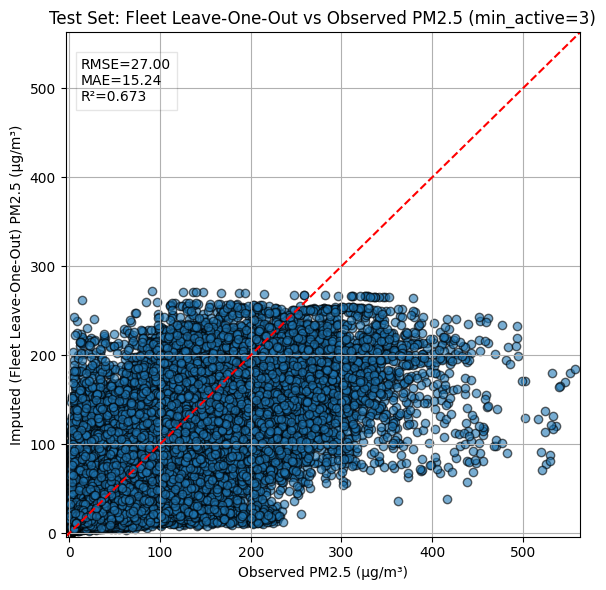

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Compute fleet leave-one-out with chosen threshold 
best_min_active = 3
loo_full = fleet_leave_one(df_full_clean, min_active=best_min_active)

# Evaluate on TEST split only
loo_test = loo_full.iloc[test_idx]
mask = ~loo_test.isna()
y_test_loo = test_df.loc[mask, "mean_pm25"]
y_pred_loo = loo_test[mask]

# Compute metrics
rmse = root_mean_squared_error(y_test_loo, y_pred_loo)
mae  = mean_absolute_error(y_test_loo, y_pred_loo)
r2   = r2_score(y_test_loo, y_pred_loo)


print(f"Fleet LOO (min_active={best_min_active})")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.3f}")

# Plot observed vs. imputed 
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
lims = [min(y_true.min(), y_pred.min()) - 5, max(y_true.max(), y_pred.max()) + 5]
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed PM2.5 (µg/m³)")
plt.ylabel("Imputed (Fleet Leave-One-Out) PM2.5 (µg/m³)")
plt.title(f"Test Set: Fleet Leave-One-Out vs Observed PM2.5 (min_active={best_min_active})")
plt.text(
    0.03, 0.95,
    f"RMSE={rmse:.2f}\nMAE={mae:.2f}\nR²={r2:.3f}",
    transform=plt.gca().transAxes, va='top',
    bbox=dict(facecolor='white', alpha=0.1)
)
plt.grid(True)
plt.tight_layout()
plt.show()


### XG Boost Using Fleet Average

We train an XGBoost regression model to predict hourly PM₂.₅ using the previously calculated fleet-average PM₂.₅ (leave-one-out) along with weather and time variables as predictors.

The model is tuned via randomized cross-validation and evaluated on the held-out test set to assess how well these features capture variability in PM 2.5

In [ ]:
# Load same train/test split

train_idx = np.load("train_idx.npy")
test_idx = np.load("test_idx.npy")

train_df = df_full_clean.iloc[train_idx].copy()
test_df  = df_full_clean.iloc[test_idx].copy()


In [ ]:
## Define features and target

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target 
features = [
    "fleet_avg_pm25",
    "monitor",
    "hour",
    "month",
    "dow",
    "mean_met_temp",
    "mean_met_rh"
]
target = "mean_pm25"

# One-hot encode monitor (categorical)
X = pd.get_dummies(df_full_clean[features], columns=["monitor"], drop_first=True)
y = df_full_clean[target]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test  = X.iloc[test_idx]
y_test  = y.iloc[test_idx]

In [ ]:
# Define model and search space 

# model setup
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    random_state=123,
    n_jobs=-1
)

param_grid = {
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 5, 10]
}

cv = KFold(n_splits=5, shuffle=True, random_state=123)

# Randomized hyperparameter search
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=123
)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best parameters:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [ ]:
# Evaluate on test set 

# predictions on test
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"XGBoost Test RMSE={rmse:.2f}  MAE={mae:.2f}  R²={r2:.3f}")

XGBoost Test RMSE=18.58  MAE=10.21  R²=0.855


In [ ]:
# Save model
best_model.save_model("xgb_pm25_model_daily.json")

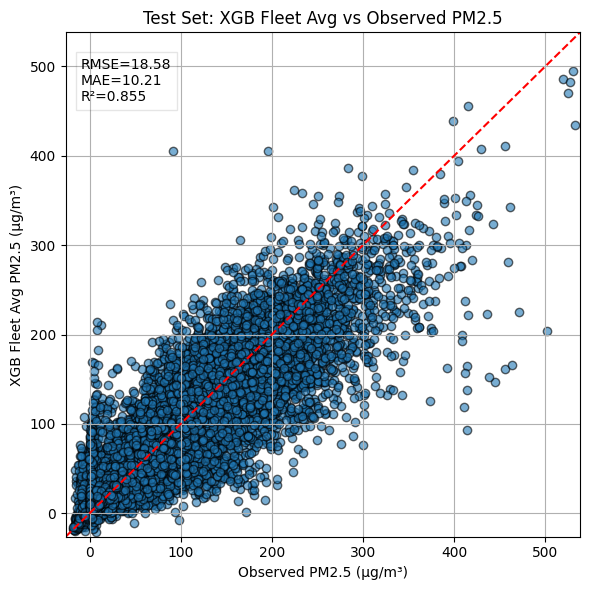

In [90]:

# Plot observed vs. imputed fro test set
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
lims = [min(y_test.min(), y_pred.min()) - 5, max(y_test.max(), y_pred.max()) + 5]
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed PM2.5 (µg/m³)")
plt.ylabel("XGB Fleet Avg PM2.5 (µg/m³)")
plt.title(f"Test Set: XGB Fleet Avg vs Observed PM2.5")
plt.text(
    0.03, 0.95,
    f"RMSE={rmse:.2f}\nMAE={mae:.2f}\nR²={r2:.3f}",
    transform=plt.gca().transAxes, va='top',
    bbox=dict(facecolor='white', alpha=0.1)
)
plt.grid(True)
plt.tight_layout()
plt.show()


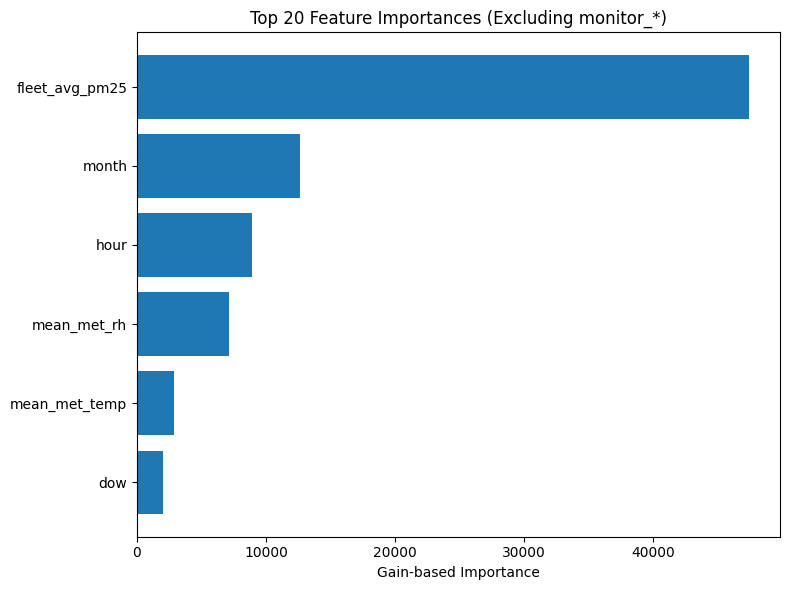

In [92]:
# Get feature importances as a dictionary
importance_dict = best_model.get_booster().get_score(importance_type='gain')

# Filter out features starting with "monitor_"
filtered_importance = {k: v for k, v in importance_dict.items() if not k.startswith("monitor_")}

# Sort and take top 20
sorted_importance = dict(sorted(filtered_importance.items(), key=lambda x: x[1], reverse=True)[:20])

# Convert to DataFrame-style plotting
plt.figure(figsize=(8,6))
plt.barh(list(sorted_importance.keys())[::-1], list(sorted_importance.values())[::-1])
plt.title("Top 20 Feature Importances (Excluding monitor_*)")
plt.xlabel("Gain-based Importance")
plt.tight_layout()
plt.show()

## XG Boost Individual Monitors Network Prediction

We next train an XGBoost model that predicts each monitor’s PM 2.5 concentration using readings from all other monitors in the network, along with weather and time-of-day features.

To prepare the data, the dataset is pivoted into a wide format so that each monitor’s hourly PM 2.5 value appears as a separate column. For each observation, the target monitor’s own column is blanked out to prevent data leakage and ensure predictions rely only on data from other monitors.

This appraoch captures spatial and temporal relationships across the fleet, allowing one site’s data to help fill gaps at another. Performance is then evaluated on the same held-out test set for direct comparison with the other models.

In [ ]:
# create copy
df = df_full_clean.copy()

# pivot wide: one column per monitor
pm_wide = (
    df[["timestamp", "monitor", "mean_pm25"]]
    .pivot(index="timestamp", columns="monitor", values="mean_pm25")
    .add_prefix("pm25_")
    .reset_index()
)

# join back to long frame (to keep target monitor info)
df_wide = df.merge(pm_wide, on="timestamp", how="left")

# remove rows with missing target
df_wide = df_wide.dropna(subset=["mean_pm25"]).reset_index(drop=True)


In [ ]:
# examine data to make sure cleaning worked 

df_wide

,monitor,date,hour,n_minute_obs_pm25,mean_pm25,n_active_pm25,fleet_average_pm25,n_minute_obs_temp,mean_met_temp,fleet_average_met_temp,...,pm25_MOD-PM-01084,pm25_MOD-PM-01085,pm25_MOD-PM-01086,pm25_MOD-PM-01087,pm25_MOD-PM-01088,pm25_MOD-PM-01089,pm25_MOD-PM-01090,pm25_MOD-PM-01091,pm25_MOD-PM-01092,pm25_MOD-PM-01093
0,MOD-00077,2024-10-31,0,60.0,42.607167,22.0,13.702668,60.0,25.703333,26.801801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MOD-00077,2024-10-31,1,60.0,29.868667,23.0,14.269829,60.0,25.303333,26.470124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MOD-00077,2024-10-31,2,60.0,27.362000,22.0,14.371607,60.0,24.958333,26.123237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MOD-00077,2024-10-31,3,60.0,37.985000,23.0,14.495907,60.0,24.740000,25.852309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MOD-00077,2024-10-31,4,60.0,30.867667,23.0,16.393675,60.0,24.708333,25.634015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454456,MOD-PM-01093,2025-08-14,14,60.0,14.218083,22.0,9.209103,60.0,34.272833,31.637852,...,-2.619785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.707706,14.218083
454457,MOD-PM-01093,2025-08-14,15,60.0,7.860950,23.0,11.495317,60.0,32.700833,31.050491,...,-3.782619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.832539,7.860950
454458,MOD-PM-01093,2025-08-14,16,60.0,13.123700,25.0,21.834801,60.0,31.172833,29.862033,...,1.785444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.226095,13.123700
454459,MOD-PM-01093,2025-08-14,17,60.0,18.663050,26.0,30.401741,60.0,30.429833,28.697850,...,1.120150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.641206,18.663050


In [ ]:
# column that corresponds to target’s own pm2.5 column
df_wide["target_col"] = "pm25_" + df_wide["monitor"]

# identify all wide-format PM cols and blank out target monitor’s own column to avoid data leakage
pm_cols = [c for c in df_wide.columns if c.startswith("pm25_")]

for col in pm_cols:
    mask = df_wide["target_col"] == col
    # Replace only those rows in this specific column with NaN
    df_wide.loc[mask, col] = np.nan


In [ ]:
# Save the processed wide-format data for reproducibility
df_wide.to_parquet("df_wide_clean.parquet")

In [ ]:
# load same train/test indices to ensure fair comparison

train_idx = np.load("train_idx.npy")
test_idx  = np.load("test_idx.npy")

# subset train/test data
train_df = df_wide.iloc[train_idx].copy()
test_df  = df_wide.iloc[test_idx].copy()

,monitor,date,hour,n_minute_obs_pm25,mean_pm25,n_active_pm25,fleet_average_pm25,n_minute_obs_temp,mean_met_temp,fleet_average_met_temp,...,pm25_MOD-PM-01085,pm25_MOD-PM-01086,pm25_MOD-PM-01087,pm25_MOD-PM-01088,pm25_MOD-PM-01089,pm25_MOD-PM-01090,pm25_MOD-PM-01091,pm25_MOD-PM-01092,pm25_MOD-PM-01093,target_col
156433,MOD-PM-00888,2024-11-11,2,60.0,26.522389,20.0,26.572958,60.0,26.046653,25.035557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pm25_MOD-PM-00888
20859,MOD-00398,2025-03-30,5,60.0,13.550231,42.0,20.017196,60.0,31.578333,28.533951,...,7.586350,-1.009520,27.592358,7.654201,18.263382,8.185699,32.225200,-0.934875,24.447031,pm25_MOD-00398
192712,MOD-PM-00893,2023-10-13,3,60.0,4.882856,32.0,4.788495,60.0,24.673802,24.512037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pm25_MOD-PM-00893
240608,MOD-PM-00898,2024-04-07,21,60.0,42.561156,34.0,37.588696,60.0,30.474082,32.346925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pm25_MOD-PM-00898
422536,MOD-PM-01083,2025-07-19,23,60.0,5.411790,22.0,13.877632,60.0,25.776667,25.231310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.699723,NaN,pm25_MOD-PM-01083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441922,MOD-PM-01090,2025-03-03,14,60.0,24.010747,47.0,27.332119,60.0,45.672167,43.005800,...,23.022670,23.472777,20.686684,20.629895,27.584456,NaN,27.476712,30.862398,29.769017,pm25_MOD-PM-01090
114190,MOD-PM-00882,2025-01-20,0,60.0,101.051773,43.0,80.367396,60.0,22.355000,25.021349,...,63.769715,58.833659,66.103255,64.893874,60.518904,71.820894,68.464512,55.773306,NaN,pm25_MOD-PM-00882
62067,MOD-PM-00876,2024-11-27,15,60.0,35.731154,24.0,40.545350,60.0,38.023000,39.274117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pm25_MOD-PM-00876
119853,MOD-PM-00883,2023-11-27,13,60.0,24.449567,35.0,7.135987,60.0,38.735500,38.151601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pm25_MOD-PM-00883


Define features and target

In [ ]:
pm_cols = [c for c in df_wide.columns if c.startswith("pm25_")]

# define predictors (all PM cols from above + weather/time covariates)
X_cols = pm_cols + [
    "hour",
    "month",
    "dow",
    "fleet_average_met_temp",
    "fleet_average_met_rh"
]

target = "mean_pm25"

# build feature and target matrices
X_train = train_df[X_cols]
y_train = train_df[target]

X_test  = test_df[X_cols]
y_test  = test_df[target]


Define and tune the model

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

# set up XGBoost with random search 
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    random_state=123,
    n_jobs=-1
)

# set up parameter grid to test 
param_grid = {
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 5, 10]
}

# 5-fold CV 
cv = KFold(n_splits=5, shuffle=True, random_state=123)

# identify best params using cross CV folds
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=123
)
search.fit(X_train, y_train)
best_xgb = search.best_estimator_
print("Best parameters:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [115]:

# predictions on test
y_pred = best_xgb.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"XGBoost All-Monitors Test RMSE={rmse:.2f}  MAE={mae:.2f}  R²={r2:.3f}")

XGBoost All-Monitors Test RMSE=17.74  MAE=9.94  R²=0.868


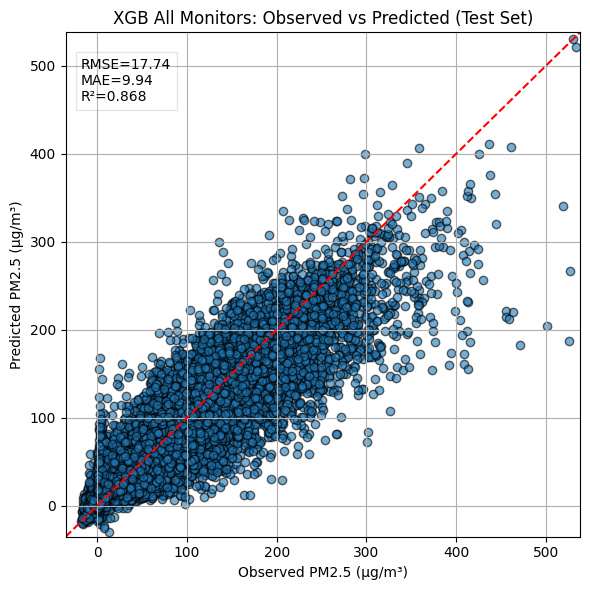

In [ ]:
# visualize observed vs predicted PM₂.₅

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
lims = [min(y_test.min(), y_pred.min())-5, max(y_test.max(), y_pred.max())+5]
plt.plot(lims, lims, 'r--')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Observed PM2.5 (µg/m³)")
plt.ylabel("Predicted PM2.5 (µg/m³)")
plt.title("XGB All Monitors: Observed vs Predicted (Test Set)")
plt.text(
    0.03, 0.95,
    f"RMSE={rmse:.2f}\nMAE={mae:.2f}\nR²={r2:.3f}",
    transform=plt.gca().transAxes, va='top',
    bbox=dict(facecolor='white', alpha=0.1)
)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# save trained model

best_xgb.save_model("xgb_pm25_model_all_monitors.json")


## Model Comparison: Fleet vs. All-Monitors XGBoost

We load the two saved XGBoost models.

For each model, predictions are aligned to the exact training feature structure to ensure consistency. We then compute standard performance metrics (RMSE, MAE, R²) and save the results and predictions for further comparison or visualization. This allows us to directly assess whether leveraging the spatial network of monitors improves accuracy beyond the simpler fleet-average model.

In [78]:
## LOAD SAVED MODELS

from xgboost import XGBRegressor

# Load the previously saved models
best_xgb_fleet = XGBRegressor()
best_xgb_fleet.load_model("xgb_pm25_model_daily.json")

best_xgb_allmon = XGBRegressor()
best_xgb_allmon.load_model("xgb_pm25_model_all_monitors.json")


In [79]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Load model-ready data and split indices
df_full_clean = pd.read_parquet("df_wide_clean.parquet")  # same structure for all
train_idx = np.load("train_idx.npy")
test_idx  = np.load("test_idx.npy")

# Load both saved models
best_xgb_fleet = XGBRegressor()
best_xgb_fleet.load_model("xgb_pm25_model_daily.json")

best_xgb_allmon = XGBRegressor()
best_xgb_allmon.load_model("xgb_pm25_model_all_monitors.json")


In [80]:
# --- Fleet-average model features ---
fleet_features = [
    "fleet_avg_pm25",
    "monitor",
    "hour",
    "month",
    "dow",
    "mean_met_temp",
    "mean_met_rh"
]

# One-hot encode monitors for fleet model
X_fleet = pd.get_dummies(df_full_clean[fleet_features], columns=["monitor"], drop_first=True)
y_fleet = df_full_clean["mean_pm25"]

# Align columns to model
X_test_fleet = X_fleet.iloc[test_idx].reindex(columns=best_xgb_fleet.feature_names_in_, fill_value=0)
y_test_fleet = y_fleet.iloc[test_idx]

# --- All-monitors model features ---
X_test_allmon = df_full_clean[best_xgb_allmon.feature_names_in_].iloc[test_idx]
y_test_allmon = df_full_clean["mean_pm25"].iloc[test_idx]


In [81]:
# Predict
y_pred_fleet  = best_xgb_fleet.predict(X_test_fleet)
y_pred_allmon = best_xgb_allmon.predict(X_test_allmon)

# Evaluation helper
def summarize_model(name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:20s} RMSE={rmse:6.2f}  MAE={mae:6.2f}  R²={r2:6.3f}")
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2}

results = []
results.append(summarize_model("Fleet XGB", y_test_fleet, y_pred_fleet))
results.append(summarize_model("All-Monitors XGB", y_test_allmon, y_pred_allmon))
results.append(summarize_model("Fleet Leave-One-Out", y_test_loo, y_pred_loo))

comparison = pd.DataFrame(results)
display(comparison)


Fleet XGB            RMSE= 16.23  MAE=  9.04  R²= 0.888
All-Monitors XGB     RMSE= 15.08  MAE=  8.51  R²= 0.903
Fleet Leave-One-Out  RMSE= 27.54  MAE= 15.88  R²= 0.682


,Model,RMSE,MAE,R²
0,Fleet XGB,16.233601,9.040470,0.887787
1,All-Monitors XGB,15.084726,8.509151,0.903107
2,Fleet Leave-One-Out,27.541317,15.875544,0.681570


In [82]:
df_compare = df_full_clean.iloc[test_idx].copy()
df_compare["pred_xgb_fleet"] = y_pred_fleet
df_compare["pred_xgb_allmon"] = y_pred_allmon

# Save for later analysis
df_compare.to_parquet("df_pm25_predictions_allmodels.parquet")
print("Saved df_pm25_predictions_allmodels.parquet")


Saved df_pm25_predictions_allmodels.parquet


## Imputation on the Full Dataset

We apply the trained all-monitors XGBoost model to the full dataset, generating hourly PM 2.5 predictions for every monitor + timestamp combination.

A complete grid of all timestamps and monitors is created, then merged with the available predictors (time, weather, and other monitors’ PM 2.5 values). For each target monitor, its own PM 2.5 column is blanked out so predictions rely only on readngs from other monitors in the network.

The model outputs predicted PM 2.5 values (pred_pm25), which are used to fill missing observations while preserving original measurements.

We visualize the resulting daily completeness to show the improvement in data coverage after imputation. 

Note: This approach can extrapolate to periods before a monitor was deployed. If used in reports or publications, this assumption should be clearly stated and interpreted cautiously.

In [83]:
from xgboost import XGBRegressor

# Load your wide-format dataset and model
df_wide = pd.read_parquet("df_wide_clean.parquet")

best_xgb_allmon = XGBRegressor()
best_xgb_allmon.load_model("xgb_pm25_model_all_monitors.json")

# Confirm features used in training
print("Model features:", len(best_xgb_allmon.feature_names_in_))


Model features: 71


In [31]:
timestamps = df_wide["timestamp"].unique()
monitors   = df_wide["monitor"].unique()

# Full grid
full_grid = pd.MultiIndex.from_product([timestamps, monitors],
                                       names=["timestamp", "monitor"]).to_frame(index=False)

print(f"Full grid: {len(full_grid):,} rows ({len(timestamps)} timestamps × {len(monitors)} monitors)")


Full grid: 1,007,358 rows (15263 timestamps × 66 monitors)


In [33]:
# Merge to bring in all predictors (weather, wide PM columns, time vars, etc.)
imputation_df = full_grid.merge(df_wide, on=["timestamp", "monitor"], how="left")

# Column that corresponds to each target’s own pm2.5
imputation_df["target_col"] = "pm25_" + imputation_df["monitor"]

# Identify wide-format PM columns
pm_cols = [c for c in imputation_df.columns if c.startswith("pm25_")]

# For each monitor, blank out its own pm column
for col in pm_cols:
    mask = imputation_df["target_col"] == col
    imputation_df.loc[mask, col] = np.nan



In [34]:
# Subset to the model’s feature columns
X_all = imputation_df.reindex(columns=best_xgb_allmon.feature_names_in_, fill_value=0)

# Predict everywhere (including rows that already have observed PM)
imputation_df["pred_pm25"] = best_xgb_allmon.predict(X_all)

# Fill observed where missing
imputation_df["pm25_filled"] = imputation_df["mean_pm25"].combine_first(imputation_df["pred_pm25"])


In [35]:
imputation_df["date"] = pd.to_datetime(imputation_df["timestamp"]).dt.date

completeness = (
    imputation_df
    .groupby(["monitor", "date"], as_index=False)
    .agg(n_obs=("pm25_filled", lambda x: x.notna().sum()))
)
completeness["pct_complete"] = completeness["n_obs"] / 24


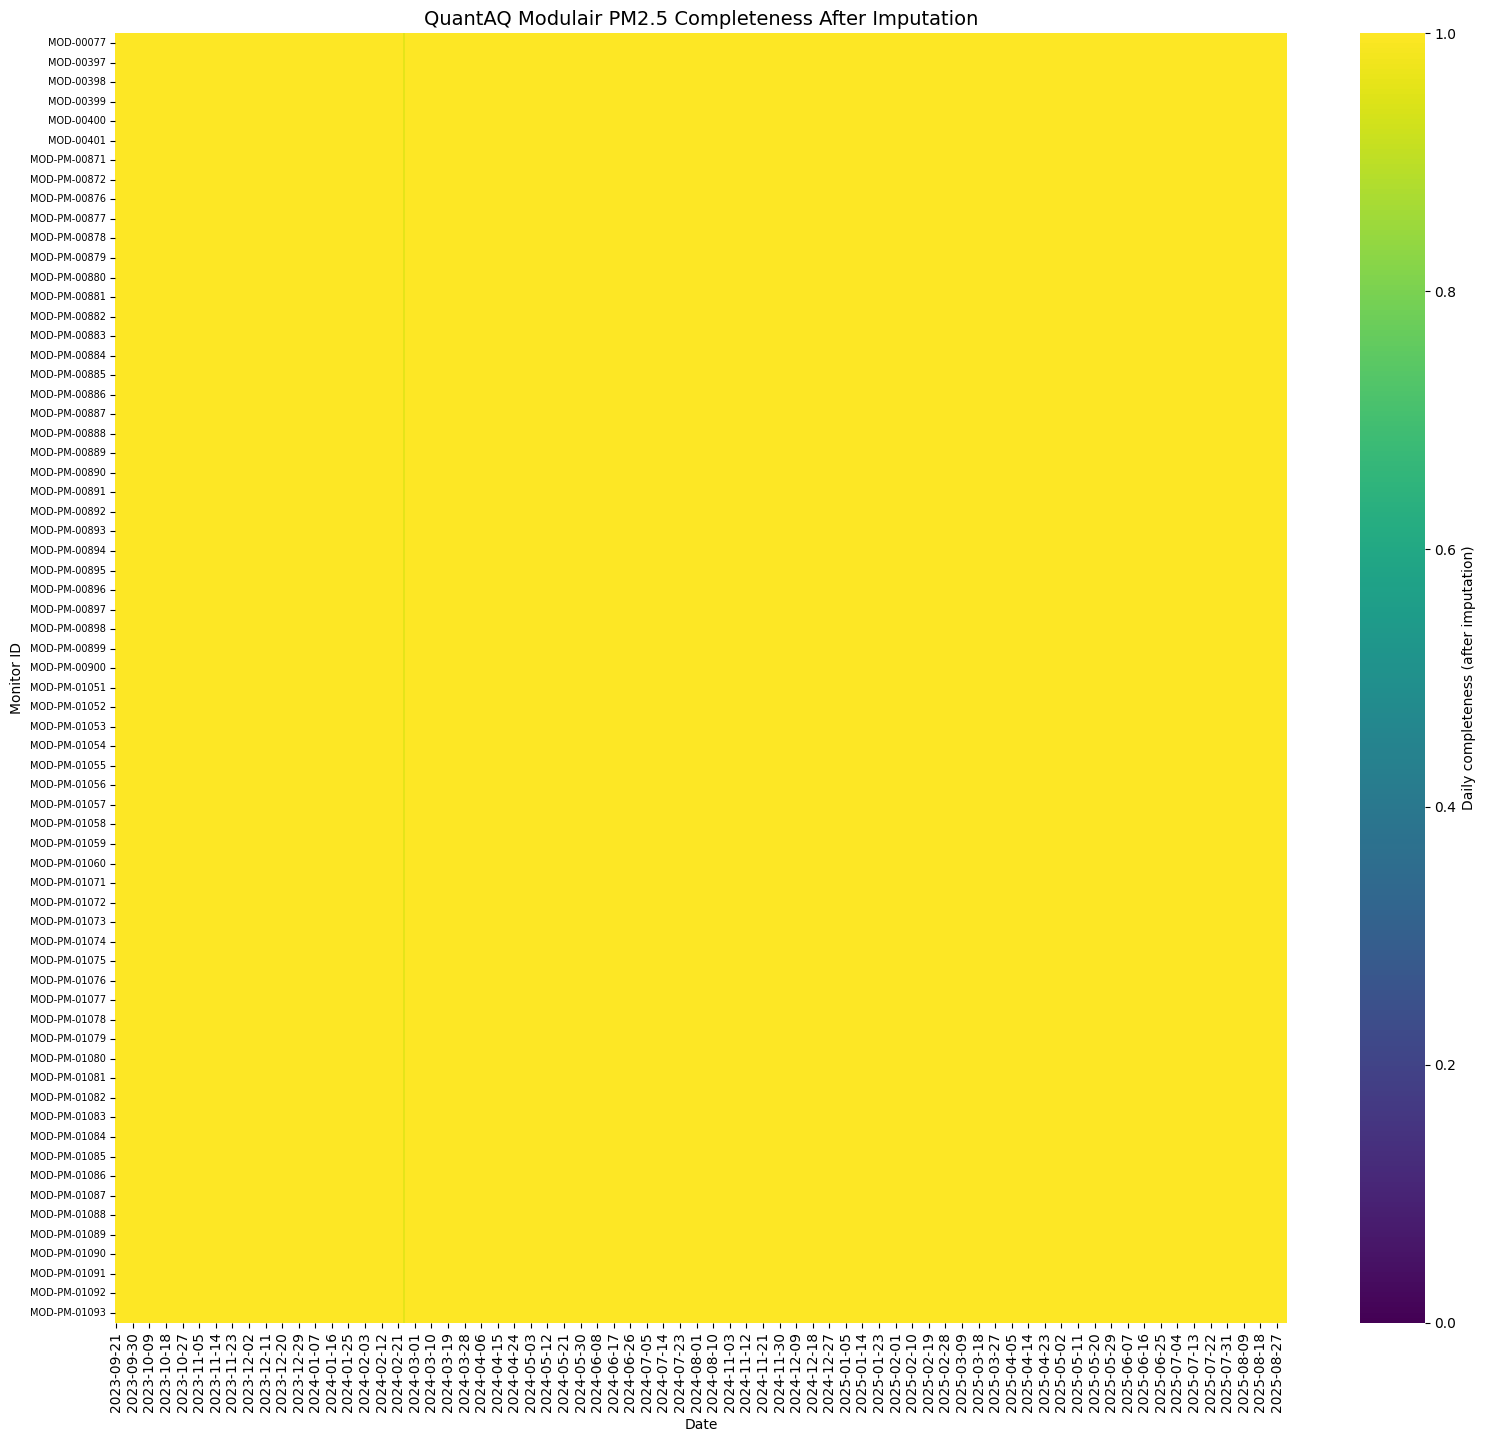

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_after = completeness.pivot(index="monitor", columns="date", values="pct_complete").fillna(0)

order = list(pivot_after.index)
fig_height = max(12, len(order) * 0.22)

plt.figure(figsize=(16, fig_height))
ax = sns.heatmap(
    pivot_after.loc[order],
    cmap="viridis",
    vmin=0, vmax=1,
    cbar_kws={"label": "Daily completeness (after imputation)"},
    mask=pivot_after.loc[order] == 0
)

ax.set_yticks(np.arange(len(order)) + 0.5)
ax.set_yticklabels(order, fontsize=7, rotation=0)
ax.set_facecolor("white")
plt.title("QuantAQ Modulair PM2.5 Completeness After Imputation", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Monitor ID")
plt.tight_layout()
plt.show()
